In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/letters-full/letters_full/б/02_03.png
/kaggle/input/letters-full/letters_full/б/02_230.png
/kaggle/input/letters-full/letters_full/б/02_112.png
/kaggle/input/letters-full/letters_full/б/02_214.png
/kaggle/input/letters-full/letters_full/б/02_116.png
/kaggle/input/letters-full/letters_full/б/02_13.png
/kaggle/input/letters-full/letters_full/б/02_173.png
/kaggle/input/letters-full/letters_full/б/02_161.png
/kaggle/input/letters-full/letters_full/б/02_02.png
/kaggle/input/letters-full/letters_full/б/02_108.png
/kaggle/input/letters-full/letters_full/б/02_81.png
/kaggle/input/letters-full/letters_full/б/02_140.png
/kaggle/input/letters-full/letters_full/б/02_128.png
/kaggle/input/letters-full/letters_full/б/02_32.png
/kaggle/input/letters-full/letters_full/б/02_192.png
/kaggle/input/letters-full/letters_full/б/02_05.png
/kaggle/input/letters-full/letters_full/б/02_203.png
/kaggle/input/letters-full/letters_full/б/02_223.png
/kaggle/input/letters-full/letters_full/б/02_130.png

Ноутбук с распознаванием строчных рукописных русских букв из датасета с изображениями на листах школьных тетрадей.

In [ ]:
# letters = os.listdir('/kaggle/input/cyrillic/Cyrillic_smooth')
# path_to = '/kaggle/input/cyrillic/Cyrillic_smooth'
# for letter in letters:
#     imgs = os.listdir(os.path.join(path_to, letter))
#     print(f'В папке с буквой {letter} лежит {len(imgs)} изображений.')
# len(letters)

In [2]:
!pip install torchsummary

In [3]:
# Загрузим необходимые модули:
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #, plot_confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# labels_map = {0: 'a', 1: 'б', 2: 'в', 3: 'г', 4: 'д', 5: 'е', 6: 'ё', 7: 'ж',
#                  8: 'з', 9: 'и', 10: 'й', 11: 'к', 12: 'л', 13: 'м', 14: 'н',
#                  15: 'о', 16: 'п', 17: 'р', 18: 'с', 19: 'т', 20: 'у', 21: 'ф',
#                  22: 'х', 23: 'ц', 24: 'ч', 25: 'ш', 26: 'щ', 27: 'ъ', 28: 'ы',
#                  29: 'ь', 30: 'э', 31: 'ю', 32: 'я'}

# labels_map = {0: 'А', 1: 'Б', 2: 'В', 3: 'Г', 4: 'Д', 5: 'Е', 6: 'Ё', 7: 'Ж',
#                  8: 'З', 9: 'И', 10: 'Й', 11: 'К', 12: 'Л', 13: 'М', 14: 'Н',
#                  15: 'О', 16: 'П', 17: 'Р', 18: 'С', 19: 'Т', 20: 'У', 21: 'Ф',
#                  22: 'Х', 23: 'Ц', 24: 'Ч', 25: 'Ш', 26: 'Щ', 27: 'Ъ', 28: 'Ы',
#                  29: 'Ь', 30: 'Э', 31: 'Ю', 32: 'Я'}

labels_map = {0: 'a', 1: 'б', 2: 'в', 3: 'г', 4: 'д', 5: 'е', 6: 'ж',
                 7: 'з', 8: 'и', 9: 'й', 10: 'к', 11: 'л', 12: 'м', 13: 'н',
                 14: 'о', 15: 'п', 16: 'р', 17: 'с', 18: 'т', 19: 'у', 20: 'ф',
                 21: 'х', 22: 'ц', 23: 'ч', 24: 'ш', 25: 'щ', 26: 'ъ', 27: 'ы',
                 28: 'ь', 29: 'э', 30: 'ю', 31: 'я'}

letter_to_idx = {'а': 0, 'б': 1, 'в': 2, 'г': 3, 'д': 4, 'е': 5, 'ж': 6,
                 'з': 7, 'и': 8, 'й': 9, 'к': 10, 'л': 11, 'м': 12, 'н': 13,
                 'о': 14, 'п': 15, 'р': 16, 'с': 17, 'т': 18, 'у': 19, 'ф': 20,
                 'х': 21, 'ц': 22, 'ч': 23, 'ш': 24, 'щ': 25, 'ъ': 26, 'ы': 27,
                 'ь': 28, 'э': 29, 'ю': 30, 'я': 31}

In [11]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                # transforms.RandomHorizontalFlip(p=0.5),
                                # transforms.RandomVerticalFlip(p=0.5),
                                # transforms.RandomRotation(degrees=(15, 15)),
                                transforms.ToTensor()])

data = datasets.ImageFolder('/kaggle/input/letters-full/letters_full', transform=transform)

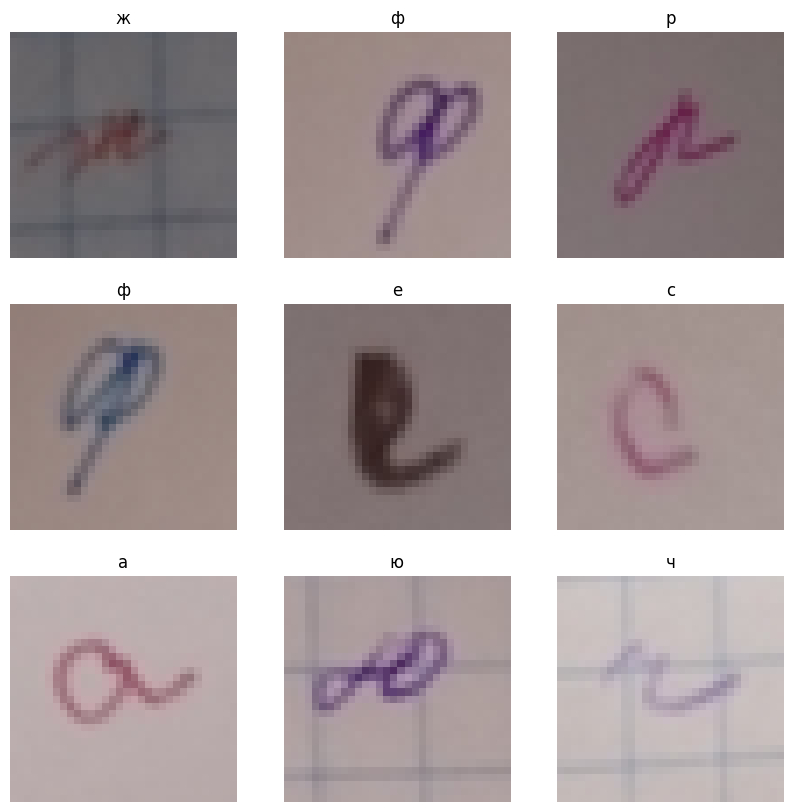

In [8]:
# Посмотрим на данные:

figure = plt.figure(figsize=(10, 10))

for i in range(1, 10):
    sample = np.random.randint(0, len(data))
    img, label = data[sample]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))

plt.show()

In [16]:
# from matplotlib.image import imread

# image  = imread('/kaggle/input/lowercase-b-on-w/Low_case_equal/в/0043_в_00.png')
# image.shape

(145, 145)

In [12]:
# Разделим датасет на обучающую и тестовую выборки:

train_val_idx, test_idx = train_test_split(list(range(len(data))),test_size=0.3,    # 0.3
                                      random_state=42)
train_idx, val_idx = train_test_split(train_val_idx,test_size=0.3,   # 0.3
                                      random_state=42)
dataset_train = torch.utils.data.Subset(data, train_idx)
dataset_val = torch.utils.data.Subset(data, val_idx)
dataset_test = torch.utils.data.Subset(data, test_idx)

In [40]:
BATCH_SIZE = 64             # 64
LEARNING_RATE = 0.0003      # 0.004  0.001, 0.0003
EPOCHS = 130                 # 

In [41]:
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
class LetterRecognizer(nn.Module):
    def __init__(self, input_size: int = [3, 128, 128], num_of_classes: int = 33):
        super(LetterRecognizer, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1),  # out_channels=32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),  # out_channels=32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),   # out_channels=64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),  # stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1), # out_channels=128
#             nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1, padding=0),     # stride=2, padding=0
            
            nn.BatchNorm2d(1024), # Убрать этот батч-норм и сделать дропаут 0.1
            nn.Flatten(),
            nn.Dropout(p=0.4),    #  0.3
            nn.Linear(in_features=409600, out_features=1024),     # 256, 128, 692224
            nn.ReLU(),
            nn.Dropout(p=0.4),    #  0.3
            ##### Этот блок вставил
#             nn.BatchNorm2d(1024),
#             nn.Linear(in_features=1024, out_features=512),     # 256, 128
#             nn.ReLU(),
#             nn.Dropout(p=0.4),
            #####
            nn.Linear(in_features=1024, out_features=num_of_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# model = torch.load('/content/contentgdrive/MyDrive/Диплом/Data/train/64_0.0003_80_15.pth')

In [72]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [42]:
# Отправим модель на device
model = LetterRecognizer()
model = model.to(device)

In [43]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)    # SGD(momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [44]:
loss_fn = nn.CrossEntropyLoss()

In [45]:
# Заведем списки accuracy_vs_epoch и loss_vs_epoch, чтобы построить графики
# изменения accuracy и loss с эпохами:
train_accuracy_vs_epoch = []
train_loss_vs_epoch = []
test_accuracy_vs_epoch = []
test_loss_vs_epoch = []

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, summary_writer):
    
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss = 0
    train_accuracy = 0
    
    model.train()

    with tqdm(dataloader, unit='batch') as tqdm_epoch:
        for images, labels in tqdm_epoch:

            # Определяем описание для tqdm
            tqdm_epoch.set_description(f'Epoch {epoch_n}')
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()
            # Изменяем веса тензора:
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            train_loss += loss.item()
            train_accuracy += correct
            # Выводим текущих потерь и точности
            tqdm_epoch.set_postfix(loss=loss.item(), accuracy=accuracy)
            
    # Средние потери и точность
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Добавляем найденные значения в списки для графика:
    train_loss_vs_epoch.append(train_loss)
    train_accuracy_vs_epoch.append(train_accuracy)

    summary_writer.add_scalar('train/loss', train_loss, epoch_n)
    summary_writer.add_scalar('train/accuracy', train_accuracy, epoch_n)

In [21]:
def test_loop(dataloader, model, loss_fn, epoch_n,  summary_writer):
    
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
        
    with torch.no_grad():  # Выключаем вычисление градиентов
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    # Добавляем найденные значения в списки для графика:
    test_loss_vs_epoch.append(test_loss)
    test_accuracy_vs_epoch.append(correct)

    summary_writer.add_scalar('test/loss', test_loss, epoch_n)
    summary_writer.add_scalar('test/accuracy', correct, epoch_n)

    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [46]:
writer = SummaryWriter('runs/resnet_ft')

start_time = time.time()

# num_of_epochs = 80

for epoch_n in range(EPOCHS):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_n, writer)
    test_loop(val_dataloader, model, loss_fn, epoch_n, writer)

end_time = time.time()
print(f'Время обучения модели составило {start_time - end_time} сек.')

writer.close()

  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.087, Avg loss: 3.489961 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.140, Avg loss: 3.435632 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.207, Avg loss: 3.374717 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.267, Avg loss: 3.318435 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.292, Avg loss: 3.285176 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.324, Avg loss: 3.255290 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.346, Avg loss: 3.234532 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.374, Avg loss: 3.206775 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.391, Avg loss: 3.191157 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.423, Avg loss: 3.167949 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.443, Avg loss: 3.148326 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.468, Avg loss: 3.124266 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.481, Avg loss: 3.107702 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.496, Avg loss: 3.093782 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.498, Avg loss: 3.087887 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.519, Avg loss: 3.069339 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.531, Avg loss: 3.058341 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.541, Avg loss: 3.050093 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.544, Avg loss: 3.040741 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.577, Avg loss: 3.021293 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.582, Avg loss: 3.016729 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.573, Avg loss: 3.013561 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.589, Avg loss: 3.004756 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.596, Avg loss: 2.995146 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.613, Avg loss: 2.982015 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.620, Avg loss: 2.979139 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.611, Avg loss: 2.981056 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.617, Avg loss: 2.971533 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.615, Avg loss: 2.977499 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.625, Avg loss: 2.970392 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.637, Avg loss: 2.957944 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.642, Avg loss: 2.956765 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.643, Avg loss: 2.955497 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.644, Avg loss: 2.950221 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.642, Avg loss: 2.947989 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.637, Avg loss: 2.953637 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.647, Avg loss: 2.946563 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.656, Avg loss: 2.935774 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.671, Avg loss: 2.929421 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.661, Avg loss: 2.935696 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.679, Avg loss: 2.919645 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.681, Avg loss: 2.916370 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.684, Avg loss: 2.916636 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.681, Avg loss: 2.913132 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.679, Avg loss: 2.920201 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.691, Avg loss: 2.907789 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.705, Avg loss: 2.904199 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.691, Avg loss: 2.907593 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.687, Avg loss: 2.909668 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.696, Avg loss: 2.899436 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.698, Avg loss: 2.895738 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.701, Avg loss: 2.894674 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.705, Avg loss: 2.892850 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.705, Avg loss: 2.890202 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.710, Avg loss: 2.886709 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.705, Avg loss: 2.895858 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.708, Avg loss: 2.901702 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.703, Avg loss: 2.891932 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.711, Avg loss: 2.888466 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.717, Avg loss: 2.886581 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.715, Avg loss: 2.881278 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.707, Avg loss: 2.888010 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.722, Avg loss: 2.879702 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.882298 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.714, Avg loss: 2.878440 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.708, Avg loss: 2.882204 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.880705 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.713, Avg loss: 2.881996 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.701, Avg loss: 2.889154 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.708, Avg loss: 2.878319 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.710, Avg loss: 2.880747 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.718, Avg loss: 2.876780 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.719, Avg loss: 2.877301 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.716, Avg loss: 2.877640 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.706, Avg loss: 2.884757 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.699, Avg loss: 2.893406 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.706, Avg loss: 2.885814 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.876845 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.721, Avg loss: 2.870292 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.718, Avg loss: 2.874836 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.726, Avg loss: 2.872996 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.725, Avg loss: 2.872676 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.721, Avg loss: 2.870812 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.726, Avg loss: 2.867875 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.725, Avg loss: 2.870090 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.722, Avg loss: 2.870440 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.868614 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.728, Avg loss: 2.870085 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.711, Avg loss: 2.883184 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.873590 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.715, Avg loss: 2.870375 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.725, Avg loss: 2.864527 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.726, Avg loss: 2.862809 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.727, Avg loss: 2.868329 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.720, Avg loss: 2.868681 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.732, Avg loss: 2.864502 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.863195 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.861432 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.732, Avg loss: 2.861203 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.716, Avg loss: 2.873379 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.730, Avg loss: 2.861825 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.859451 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.860080 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.862169 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.863226 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.728, Avg loss: 2.862193 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.737, Avg loss: 2.860678 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.736, Avg loss: 2.858617 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.730, Avg loss: 2.859883 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.730, Avg loss: 2.863224 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.723, Avg loss: 2.863194 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.729, Avg loss: 2.860469 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.854994 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.856263 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.742, Avg loss: 2.855516 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.859907 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.727, Avg loss: 2.864199 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.716, Avg loss: 2.869365 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.729, Avg loss: 2.860441 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.726, Avg loss: 2.859458 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.734, Avg loss: 2.858883 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.735, Avg loss: 2.856708 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.856378 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.855222 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.851666 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 2.856760 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 2.859046 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.732, Avg loss: 2.857396 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.729, Avg loss: 2.859984 



  0%|          | 0/59 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.730, Avg loss: 2.858845 

Время обучения модели составило -2924.7346341609955 сек.


In [27]:
torch.save(model, 'Model_7_School_73_perc.pth')

In [42]:
# model_loaded = torch.load('/kaggle/working/Model_1_86_perc.pth')
# model.to(device)

In [47]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 30, 30]           3,584
              ReLU-2          [-1, 128, 30, 30]               0
         MaxPool2d-3          [-1, 128, 29, 29]               0
       BatchNorm2d-4          [-1, 128, 29, 29]             256
            Conv2d-5          [-1, 256, 27, 27]         295,168
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 26, 26]               0
       BatchNorm2d-8          [-1, 256, 26, 26]             512
            Conv2d-9          [-1, 512, 24, 24]       1,180,160
             ReLU-10          [-1, 512, 24, 24]               0
        MaxPool2d-11          [-1, 512, 23, 23]               0
      BatchNorm2d-12          [-1, 512, 23, 23]           1,024
           Conv2d-13         [-1, 1024, 21, 21]       4,719,616
             ReLU-14         [-1, 1024,

In [49]:
df_preds_val = pd.DataFrame(columns=['y_pred', 'y_true'])
writer = SummaryWriter('runs/resnet_ft')

# Временно переведм модель в режим eval:
model.eval()            # model.eval()
for image, label in tqdm(dataset_test, total=len(dataset_test)):
    with torch.inference_mode():
        image = image.to(device)
        image = image.unsqueeze(0)
        logits = model(image)   #  model(image)
        
        df_pred = pd.DataFrame([[torch.argmax(logits).item(), label]], columns=['y_pred', 'y_true'])
        df_preds_val = pd.concat([df_preds_val, df_pred], ignore_index=True)

writer.close()

  0%|          | 0/2277 [00:00<?, ?it/s]

In [ ]:
print(idx_to_class['К'])

In [50]:
# !!!!! Проверить idx_to_class

# letter_to_idx = {'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ё': 6, 'Ж': 7,
#                  'З': 8, 'И': 9, 'Й': 10, 'К': 11, 'Л': 12, 'М': 13, 'Н': 14,
#                  'О': 15, 'П': 16, 'Р': 17, 'С': 18, 'Т': 19, 'У': 20, 'Ф': 21,
#                  'Х': 22, 'Ц': 23, 'Ч': 24, 'Ш': 25, 'Щ': 26, 'Ъ': 27, 'Ы': 28,
#                  'Ь': 29, 'Э': 30, 'Ю': 31, 'Я': 32}

idx_to_class = {v: k for k, v in data.class_to_idx.items()}      #  data     test_data

df_preds_val['y_pred'] = df_preds_val['y_pred'].apply(lambda x:idx_to_class[x])
df_preds_val['y_true'] = df_preds_val['y_true'].apply(lambda x:idx_to_class[x])

df_preds_val['y_pred'] = df_preds_val['y_pred'].apply(lambda x:x.replace('_', ' ').title())
df_preds_val['y_true'] = df_preds_val['y_true'].apply(lambda x:x.replace('_', ' ').title())

# df_preds_val['y_true_letter_my_idx'] = df_preds_val['y_true_letter'].apply(lambda x:letter_to_idx[x])
# df_preds_val['y_pred_letter_my_idx'] = df_preds_val['y_pred_letter'].apply(lambda x:letter_to_idx[x])

In [47]:
# # df_preds_val.sort_values(['y_true', 'y_pred'])
# df_preds_val['y_true_idx'] = df_preds_val['y_true'].apply(lambda x: letter_to_idx[x])
# df_preds_val['y_pred_idx'] = df_preds_val['y_pred'].apply(lambda x: letter_to_idx[x])
# df_preds_val = df_preds_val.sort_values(['y_true', 'y_pred'])
# print(df_preds_val)

      y_pred y_true  y_true_idx  y_pred_idx
14         А      А           0           0
28         А      А           0           0
29         А      А           0           0
82         А      А           0           0
105        А      А           0           0
...      ...    ...         ...         ...
10879      Я      Я          32          32
10894      Я      Я          32          32
10961      Я      Я          32          32
11012      Я      Я          32          32
11019      Я      Я          32          32

[11036 rows x 4 columns]


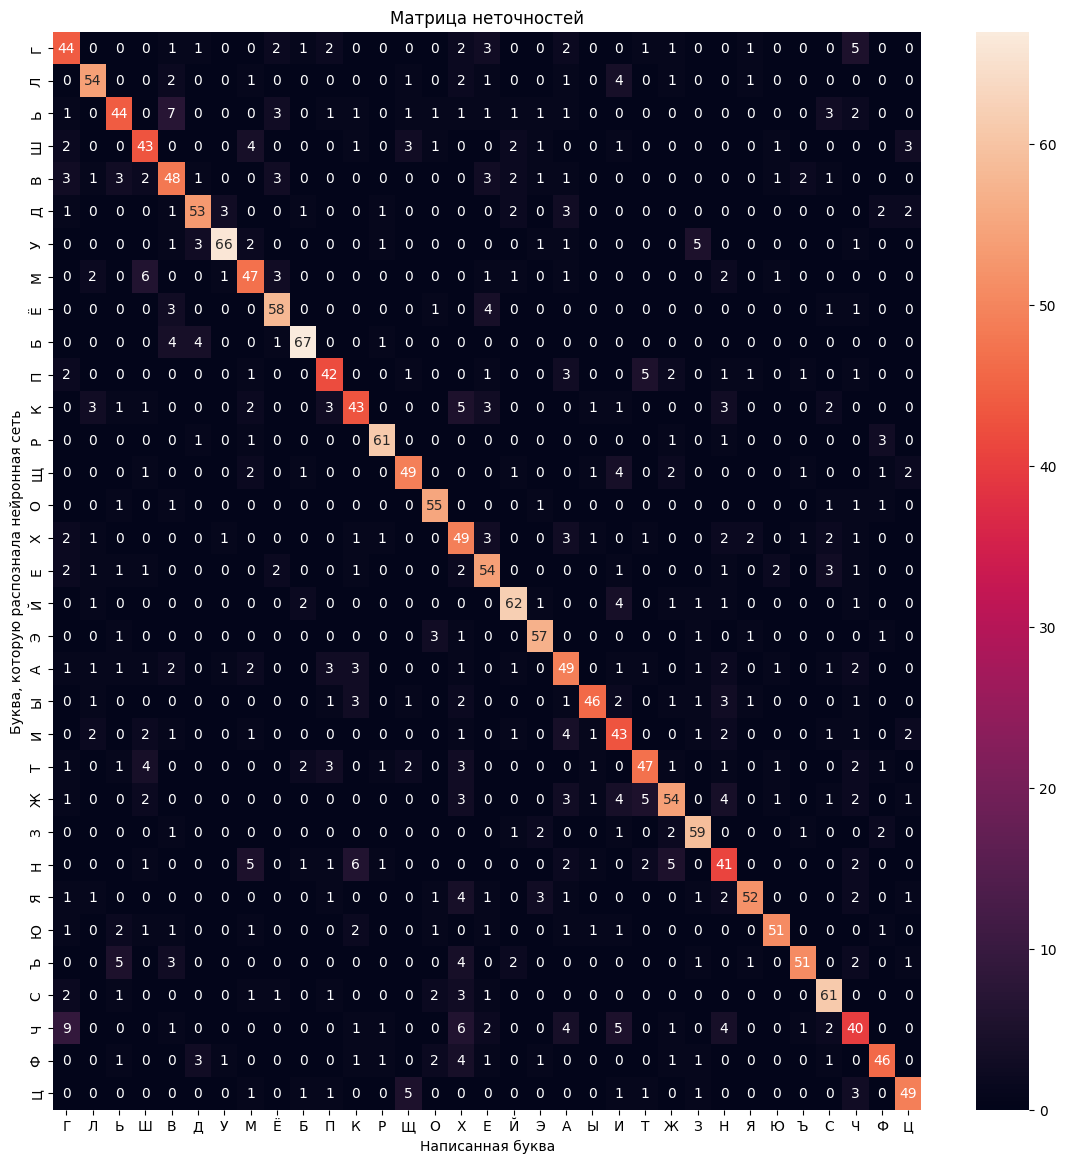

In [52]:
labels = df_preds_val['y_true'].unique()
cm = confusion_matrix(df_preds_val['y_true'], df_preds_val['y_pred'], labels=labels)
# labels = df_preds_val['y_pred'].unique()
# cm = confusion_matrix(df_preds_val['y_true'], df_preds_val['y_pred'], labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# sns.heatmap(cm, annot=True, fmt='d', ax=ax, annot_kws={"size": 14},
# #            xticklabels = ['a', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й',
# #                           'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф',
# #                           'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'],
# #            yticklabels = ['a', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й',
# #                           'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф',
# #                           'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'])
#             xticklabels = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й',
#                           'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф',
#                           'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я'],
#            yticklabels = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й',
#                           'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф',
#                           'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я'])


ax.set_xlabel('Написанная буква')
ax.set_ylabel('Буква, которую распознала нейронная сеть')
ax.set_title('Матрица неточностей')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('Model_8_School_74_perc_conf_matrix.png')

In [48]:
writer = SummaryWriter('runs/resnet_ft')

test_loop(test_dataloader, model, loss_fn, EPOCHS, writer)

writer.close()

Test Metrics: 
 Accuracy: 0.740, Avg loss: 2.849873 



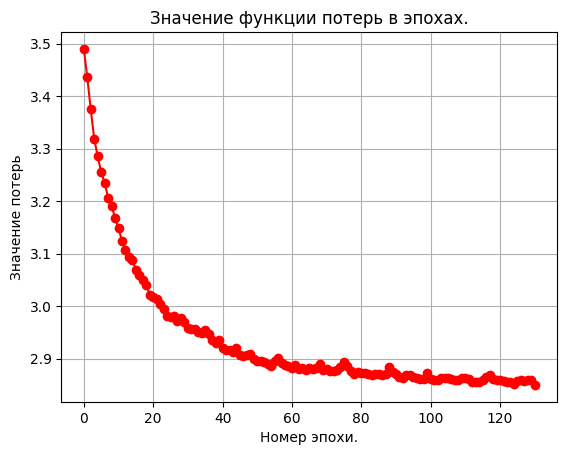

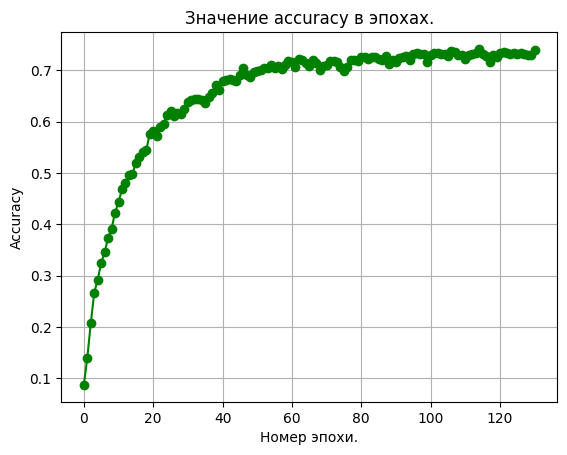

In [53]:
x = [i for i in range(len(test_loss_vs_epoch))]

plt.plot(x, test_loss_vs_epoch, 'o-r')
plt.xlabel('Номер эпохи.')
plt.ylabel('Значение потерь')
plt.title('Значение функции потерь в эпохах.')
plt.grid(True)
plt.savefig('Model_8_School_74_perc_Losses_graph.png')
plt.show()

plt.plot(x, test_accuracy_vs_epoch, 'o-g')
plt.xlabel('Номер эпохи.')
plt.ylabel('Accuracy')
plt.title('Значение accuracy в эпохах.')
plt.savefig('Model_8_School_74_perc_Accuracy_graph.png')
plt.grid(True)
plt.show()